# Web Scrapping

Nous allons récupérer nos données depuis les avis de Google Maps

In [1]:
from selenium.common import NoSuchElementException, TimeoutException
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
import time
import chromedriver_autoinstaller

google_url = "https://www.google.com/maps/place/Googleplex/@37.4220656,-122.0862784,17z/data=!3m1!4b1!4m6!3m5!1s0x808fba02425dad8f:0x6c296c66619367e0!8m2!3d37.4220656!4d-122.0840897!16zL20vMDNiYnkx?entry=ttu"

chromedriver_autoinstaller.install()

driver = webdriver.Chrome()

driver.set_window_size(1024, 600)
driver.maximize_window()

driver.get(google_url)

names = []
rating = []
dates = []
comments = []

try:
    # Wait for consent page to load
    accept_all_button = WebDriverWait(driver, 10).until(
        # By css_selector (1 or more classes) is more robust choice because by class_name can only handle 1 class
        EC.presence_of_element_located((By.CSS_SELECTOR, "[jsname='b3VHJd']"))
    )
    # Accept cookies because they are good
    accept_all_button.click()
except:
    print("An error occurred when trying to accept Google's terms of conditions.")

# get numbers of comments
total_reviews = 1
try:
    # Wait for consent page to load
    reviews_info = WebDriverWait(driver, 10).until(
        # By css_selector (1 or more classes) is more robust choice because by class_name can only handle 1 class
        EC.presence_of_element_located((By.CSS_SELECTOR, ".F7nice"))
    )
    # get all the spans
    span_elements = reviews_info.find_elements(By.TAG_NAME, 'span')
    print(len(span_elements))
    total_reviews = int(span_elements[8].text[1:-1].replace(",", ""))
    print(total_reviews)
    if total_reviews > 500:
        total_reviews = 500
    print(total_reviews)
except:
    print("Couldn't get number of reviews.")

# get to reviews
try:
    reviews_button = WebDriverWait(driver, 10).until(
        # EC.presence_of_element_located((By.CSS_SELECTOR, "[data-tab-index='1']"))
        # EC.presence_of_element_located((By.CSS_SELECTOR, "[aria-label*='Review']"))
        EC.presence_of_element_located((By.CSS_SELECTOR, "[jslog='145620;track:click;']"))
    )
    reviews_button.click()
except:
    print("An error occurred when trying to get to reviews.")

# scroll until the end
try:
    scrollable_div = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".m6QErb.DxyBCb.kA9KIf.dS8AEf"))
    )
    last_height = driver.execute_script("return arguments[0].scrollHeight", scrollable_div)
    # get number of currently loaded comments
    n_comment_divs = len(driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium "))
    # limits to 500 reviews
    while n_comment_divs < total_reviews:
        # scroll to the bottom
        driver.execute_script(
            "arguments[0].scrollTop = arguments[0].scrollHeight", scrollable_div
        )
        # wait for the page to load
        time.sleep(1.3)
        # recalculate number of loaded divs
        try:
            # wait for the number of comments to change with a maximum wait time of 10 seconds
            WebDriverWait(driver, 10).until(lambda x: len(x.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium ")) > n_comment_divs)
            # recalculate number of loaded divs
            n_comment_divs = len(driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium "))
        except TimeoutException:
            # if after 10 seconds the number of comments hasn't changed, break
            break
        # calculate new scroll height and compare with the last scroll height
        new_height = driver.execute_script("return arguments[0].scrollHeight", scrollable_div)
        if new_height == last_height:
            break
        last_height = new_height
except:
    print("Couldn't scroll...")

# open the comments fully (see more)
try:
    # gather all see more buttons and click them
    all_see_more_buttons = driver.find_elements(By.CSS_SELECTOR, ".w8nwRe.kyuRq")
    for button in all_see_more_buttons:
        button.click()
except:
    print("Couldn't click all see more buttons.")

# extract text
try:
    comment_divs = driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium ")
    # there is necessarily a name, rating and a date but not comment
    for comment in comment_divs:
        # get name
        names.append(comment.find_element(By.CLASS_NAME, "d4r55 ").text)
        # get review but on the case of hotels, it might be different disposition
        try:
            rating.append(comment.find_element(By.CLASS_NAME, "kvMYJc").get_attribute("aria-label"))
        except:
            rating.append(comment.find_element(By.CLASS_NAME, "fzvQIb").text)
        # get dates, in case of hotels, might be different
        try:
            dates.append(comment.find_element(By.CLASS_NAME, "rsqaWe").text)
        except:
            date_element = comment.find_element(By.CLASS_NAME, "xRkPPb")
            date_text = driver.execute_script('return arguments[0].firstChild.textContent;', date_element).strip()
            dates.append(date_text)
        # verify that there is comment and add, else add empty string
        text = ""
        try:
            myened_element = comment.find_element(By.CLASS_NAME, "MyEned")
            text = myened_element.find_element(By.CLASS_NAME, "wiI7pd").text
        except NoSuchElementException:
            text = ""
        comments.append(text)
except:
    print("Something happened when trying to parse reviews...")

finally:
    driver.quit()

zipped = list(zip(names, rating, dates, comments))
dictionary = {key: (v1, v2, v3) for key, v1, v2, v3 in zipped}

print(dictionary)

11
Couldn't get number of reviews.
{'Caroline Vidal': ('5\xa0étoiles', 'il y a un an', 'Voir les immenses locaux de Google et comment les employés ont l’air d’être content de travailler est une expérience à tenter si vous passer par là.\nLe cadre de travail vu de l’extérieur, puisque c’est la seule chose à voir( je ne connais personne chez Google dommage), est calme et reposant. Terrain de volley, nombreux endroits à l’ombre et vélo en libre service.\nDommage que le jour de notre visite le Google shop ait été fermé ☹️\nLe visitor center nous a dit qu’il ouvrirait d’ici 5mois ( nov 22) quand l’énorme bâtiment en construction serait terminé, déçue 😞'), 'Virgile': ('5\xa0étoiles', 'il y a 11 mois', 'Superbe campus ‼️\n\nVous pouvez vous promenez au milieu des employés de Google et voir tous les bâtiments de l’extérieur.\n\nBalade à faire en 20/30 minutes\n\nJe recommande a 100% 🏄🏼\u200d♂️'), 'Vassor Max': ('5\xa0étoiles', 'il y a 5 ans', "On s'est branche au wifi googleguest,j'ai pris un 

# Data Cleaning


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

## Loading the data

In [3]:
# Convert dict to Dataframe

df = pd.DataFrame.from_dict(dictionary, orient='index', columns=['grading', 'date', 'Text'])
df = df.reset_index().rename(columns={"index": "Name"})

df = df.dropna()

# Replace the values in grading by int 
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Replace date by the number of months
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return 0
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return int(date_array[0])
        return 1
    elif date_array[0].isdigit():
        return int(date_array[0])*12
    return 12

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Rename column index to "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Add column Language to DataFrame

# For consistent detections
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

,Name,grading,date,Text,Language
ID,,,,,
0,Caroline Vidal,5,12,Voir les immenses locaux de Google et comment ...,fr
1,Virgile,5,1,Superbe campus ‼️\n\nVous pouvez vous promenez...,fr
2,Vassor Max,5,12,"On s'est branche au wifi googleguest,j'ai pris...",fr
3,Yann D.,1,1,"Impossible de publier des avis sur Google map,...",fr
4,Guillaume G,1,1,L'IA qui traite les commentaires de google est...,fr
5,Rebecca Carrier,4,12,Une belle promenade! Je conseille toutefois de...,fr
6,Mathys LYOEN-JARRY,4,1,Malheureusement fermé quand j'y étais. Et une ...,fr
7,Flo Make My Trip,5,12,Énorme d'être là. Le lieu est en fait très éte...,fr
8,françois SALMON,1,1,Paf je note cette entreprise !\nMalheureusemen...,fr


## Translation 

Etant donné que le modèle ne fonctionne que sur les textes rédigés en anglais. Nous allons tout d'abord vérifier si les textes sont en anglais. Sinon, nous traduisons le texte.

In [4]:
from deep_translator import GoogleTranslator

def translate_text(df):
    for i, row in df.iterrows():
        if row['Language'] != 'en':
            text = row['Text']
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            df.at[i, 'Text'] = translated_text
            df.at[i, 'Language'] = 'en'
    return df

# Apply the function to the DataFrame
df = translate_text(df)
df

,Name,grading,date,Text,Language
ID,,,,,
0,Caroline Vidal,5,12,Seeing the huge premises of Google and how the...,en
1,Virgile,5,1,Stunning campus ‼️\n\nYou can walk around amon...,en
2,Vassor Max,5,12,"We connected to googleguest wifi, I took a scr...",en
3,Yann D.,1,1,"Impossible to publish opinions on Google map, ...",en
4,Guillaume G,1,1,The AI ​​that processes google comments sucks....,en
5,Rebecca Carrier,4,12,"A nice walk! However, I advise you to do it wi...",en
6,Mathys LYOEN-JARRY,4,1,Unfortunately closed when I was there. And a n...,en
7,Flo Make My Trip,5,12,Huge to be there. The place is actually very l...,en
8,françois SALMON,1,1,"Wow, I'm rating this company!\nUnfortunately I...",en


## EDA

Nous allons ensuite faire une exploration rapide des données.

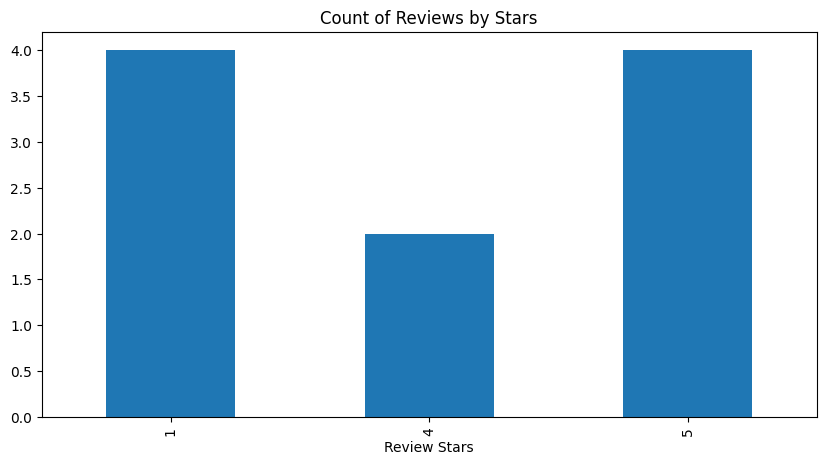

In [5]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Sentiment Analysis

Nous avons tester 3 modèles. Nous avons décidé de garder le modèle Roberta. Les autrces modèles ont été mis en commentaires afin de ne pas rallonger le temps d'exécution du Notebook.

### Roberta

In [6]:
from transformers import pipeline
from transformers import AutoTokenizer

c:\Users\Mrics\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Sentiment Analysis with Roberta
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dico = pd.DataFrame(nlp(text))
            dico['ID'] = index
            res = pd.concat([res, dico], axis=0)

# Replace labels to negative, positive, neutral
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


,Name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,Caroline Vidal,5,12,Seeing the huge premises of Google and how the...,en,POSITIVE,0.488695
1,Virgile,5,1,Stunning campus ‼️\n\nYou can walk around amon...,en,POSITIVE,0.968273
2,Vassor Max,5,12,"We connected to googleguest wifi, I took a scr...",en,POSITIVE,0.818175
3,Yann D.,1,1,"Impossible to publish opinions on Google map, ...",en,NEGATIVE,0.913838
4,Guillaume G,1,1,The AI ​​that processes google comments sucks....,en,NEGATIVE,0.945134
5,Rebecca Carrier,4,12,"A nice walk! However, I advise you to do it wi...",en,POSITIVE,0.800920
6,Mathys LYOEN-JARRY,4,1,Unfortunately closed when I was there. And a n...,en,NEGATIVE,0.516498
7,Flo Make My Trip,5,12,Huge to be there. The place is actually very l...,en,POSITIVE,0.789372
8,françois SALMON,1,1,"Wow, I'm rating this company!\nUnfortunately I...",en,NEGATIVE,0.824942


## nlptown/bert-base-multilingual-uncased-sentiment

Bien que ce modèle permet d'analyser les textes en plusieurs langues (dont le français), la target était un nombre d'étoile sur 5. Donc ce n'était pas pertinent dans notre cas, étant donné que nous avons déjà les étoiles des avis sur Google.

In [8]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu
"""
nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':

        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dico = pd.DataFrame(nlp(text))
            dico['ID'] = index
            res = pd.concat([res, dico], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={'label': 'label (Bert), over 5', 'score': 'score (Bert)'})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df
"""
# print(df.isnull().sum())
# print(f"Negative: {df[df['label (roberta)'] == 'NEGATIVE'].count()}, Positive: {df[df['label (roberta)'] == 'POSITIVE'].count()}, Neutral: {df[df['label (roberta)'] == 'NEUTRAL'].count()}")


'\nnlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\' or langue == \'fr\' or langue == \'es\' or langue == \'it\' or langue == \'de\' or langue == \'nl\':\n\n        tokens = tokenizer.encode(text, return_tensors=\'pt\')\n\n        if len(tokens[0]) <= 512:\n            dico = pd.DataFrame(nlp(text))\n            dico[\'ID\'] = index\n            res = pd.concat([res, dico], axis=0)\n\n# Remplacement des valeurs\nres[\'label\'] = res[\'label\'].replace(\'1 star\', int(1))\nres[\'label\'] = res[\'label\'].replace(\'2 stars\', int(2))\nres[\'label\'] = res[\'label\'].replace(\'3 stars\', int(3))\nres[\'label\'] = res[\'label\'].replace(\'4 stars\', int(4))\nres[\'label\'] = res[\'label\'].replace(\'5 stars\', int(5))\nres["ID"] 

## Using Sklearn

Ce modèle est similaire à celui de Roberta, mais les scores obtenus sont moins bons.

In [9]:
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df.drop(df[df['label (roberta)'].isna()].index)

# Assume X is your list of texts and y is your list of labels
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)

# Transform the text data into numerical vectors
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Test the classifier
predictions = clf.predict(X_test_vectors)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# DISPLAY CONFUSION MATRIX
# Transpose the confusion matrix
cm = cm.T
# Define the labels of the matrix
labels = ['Negative', 'Neutral', 'Positive']
# Create a dataframe from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Display the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()
"""

"\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\ndf = df.drop(df[df['label (roberta)'].isna()].index)\n\n# Assume X is your list of texts and y is your list of labels\nX_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)\n\n# Transform the text data into numerical vectors\nvectorizer = CountVectorizer()\nX_train_vectors = vectorizer.fit_transform(X_train)\nX_test_vectors = vectorizer.transform(X_test)\n\n# Train the classifier\nclf = MultinomialNB()\nclf.fit(X_train_vectors, y_train)\n\n# Test the classifier\npredictions = clf.predict(X_test_vectors)\n\n# Calculate metrics\naccuracy = accuracy_score(y_test, predictions)\nprecision = precision_score(y_test, predictions, average='weighted', zero_division=0)\nrecall = recall_score(y_test, pr

## Score du modèle

In [10]:
test_df = pd.read_csv('dataset1.csv', sep=';')
print(test_df.shape)
test_df.head()

(5015, 5)


,Name,grading,date,Text,Target
0,Alvin Alias,1 star,7 months ago,Over priced and unfriendly staff,NaN
1,Wissem Smaali,1 star,11 months ago,"À éviter\r\nLe Pirée boulangerie de Vitry , le...",0
2,ted tenore,1 star,4 months ago,Je précise l’étoile je le donne que pour les c...,0
3,Sly yo!,1 star,4 months ago,Dommage pour le pâtissier qui ce démène et mes...,0
4,Emiie.R D,1 star,a month ago,Dommage les produits sont très bon mais les ve...,0


In [11]:
test_df = test_df.dropna()
test_df.shape

(87, 5)

In [12]:
X_test = test_df['Text']
y_test = test_df['Target']
X_test

1       À éviter\r\nLe Pirée boulangerie de Vitry , le...
2       Je précise l’étoile je le donne que pour les c...
3       Dommage pour le pâtissier qui ce démène et mes...
4       Dommage les produits sont très bon mais les ve...
5       Si je pouvais mettre -1000 je l’aurais fait, j...
                              ...                        
3599    Service de qualité au rayon dressing/rangement...
4482    Très bon restaurant, avec un personnel très sy...
4483    Une valeur sûre à Beauvais. Bon accueil et tar...
4484    Très bon burger, et très bonne bière en pressi...
4487    Restaurant sympa et très bon service. Je recom...
Name: Text, Length: 87, dtype: object

In [13]:
# Traduire les phrases en anglais

X_test = X_test.apply(GoogleTranslator(source='auto', target='en').translate)
X_test

1       To avoid\r\nThe Piraeus bakery in Vitry, the s...
2       I specify the star I give it only for the croi...
3       Too bad for the pastry chef who struggles and ...
4       Too bad the products are very good but the sal...
5       If I could put -1000 I would have, I asked for...
                              ...                        
3599    Quality service in the dressing room/storage d...
4482    Very good restaurant, with very friendly staff...
4483    A safe bet in Beauvais. Good reception and fai...
4484    Very good burger, and very good draft beer. Go...
4487    Nice restaurant and very good service. I recom...
Name: Text, Length: 87, dtype: object

In [14]:
y_pred = X_test.apply(lambda x: nlp(x)[0]['label'])

In [15]:
# remplacer LABEL_0 par 0, LABEL_1 par 1 et LABEL_2 par 2
y_pred = y_pred.replace('LABEL_0', 0)
y_pred = y_pred.replace('LABEL_1', 1)
y_pred = y_pred.replace('LABEL_2', 2)
y_pred

1       0
2       0
3       0
4       0
5       1
       ..
3599    2
4482    2
4483    2
4484    2
4487    2
Name: Text, Length: 87, dtype: int64

In [16]:
def accuracy(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [17]:
# Replace value in line 1515 by 0 
y_test = y_test.replace('À', 0)

In [18]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [19]:
score = accuracy(y_test, y_pred)
print(f"Accuracy: {score:.2f}")

Accuracy: 0.70


# Data Visualisation

Maintenant, nous devons faire des graphs pertinents afin d'aider les entreprises à comprendre les avis des clients. Nous allons d'abord montrer l'évolution du nombre d'avis positifs, négatifs et neutres au fil du temps. Ensuite, nous allons séléctionner trois noms qui reviennent le plus dans les avis, pour afficher ensuite un pie chart qui montre si les avis associés à ces noms sont positifs ou négatifs. 

In [20]:
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import re
import plotly.subplots as sp
from plotly.subplots import make_subplots

In [21]:
figs_json = []

## Subgraph Pourcentage de sentiments positifs, neutres, négatifs au fil du temps (3 courbes, un pour chaque)

In [22]:
df_groupby_date_label = df.groupby(['date', 'label (roberta)']).size().unstack(fill_value=0)
df_groupby_date_label

label (roberta),NEGATIVE,POSITIVE
date,,
1,4,1
12,1,4


In [23]:
for col in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
        if col not in df_groupby_date_label.columns:
            df_groupby_date_label[col] = 0
df_groupby_date_label['POSITIVE'] = df_groupby_date_label['POSITIVE'].apply(lambda x: x * 1.5)
df_groupby_date_label['TOTAL'] = df_groupby_date_label[['NEGATIVE', 'NEUTRAL', 'POSITIVE']].sum(axis=1)
df_groupby_date_label

label (roberta),NEGATIVE,POSITIVE,NEUTRAL,TOTAL
date,,,,
1,4,1.5,0,5.5
12,1,6.0,0,7.0


In [24]:
print(df_groupby_date_label.index)
df_groupby_date_label.drop(df_groupby_date_label[df_groupby_date_label.index > 12].index, inplace=True)
df_groupby_date_label = df_groupby_date_label.sort_index(ascending=False)
# Since graph_objects automatically sort the index in ascending, we put it in string, so it doesn't sort
df_groupby_date_label.index = df_groupby_date_label.index.astype(str)
df_groupby_date_label

Index([1, 12], dtype='int64', name='date')


label (roberta),NEGATIVE,POSITIVE,NEUTRAL,TOTAL
date,,,,
12,1,6.0,0,7.0
1,4,1.5,0,5.5


In [25]:
fig1 = go.Figure()

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100,
                      line=dict(color='#00cc96'),
                      name='Positive',
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100,
                      name='Negative',
                      line=dict(color='#eb533a'),
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100,
                      name='Neutral',
                      line=dict(color='#636efa'),
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.update_layout(title='Sentiment Analysis over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage %', yaxis_range=[0,100])
fig1.show()

c:\Users\Mrics\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [26]:
test_json = fig1.to_json()

In [27]:
#figs_json.append(pio.to_json(fig))

## Subgraph

In [28]:
y_values = df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#00cc96'),
                         name='Positive',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig2.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0])  for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig2.update_layout(title='Positive Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig2.show()

## Subgraph

In [29]:
y_values = df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#eb533a'),
                         name='Negative',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig3.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0]) for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig3.update_layout(title='Negative Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig3.show()

## Subgraph

In [30]:
y_values = df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#636efa'),
                         name='Neutral',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig4.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0]) for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig4.update_layout(title='Neutral Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig4.show()

C:\Users\Mrics\AppData\Local\Temp\ipykernel_21056\2985659729.py:9: RuntimeWarning:

invalid value encountered in double_scalars



## Graph

In [31]:

import plotly.graph_objects as go

# Create subplots with 4 rows and 1 column
fig = sp.make_subplots(rows=4, cols=1)

# Add all figures
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=2, col=1)
for trace in fig3.data:
    fig.add_trace(trace, row=3, col=1)
for trace in fig4.data:
    fig.add_trace(trace, row=4, col=1)

fig.update_yaxes(range=[0, 100])
fig.update_layout(title_text="Sentiment Analysis over Time", height=800)

fig.add_annotation(text="Month(s) ago", xref="paper", yref="paper", x=0.5, y=-0.1, showarrow=False)
fig.add_annotation(text="Percentage %", textangle=-90, xref="paper", yref="paper", x=-0.1, y=0.5, showarrow=False)

# Show the combined subplots
fig.show()

In [32]:
figs_json.append(pio.to_json(fig))

## Graph Positif, neutre, négatif : diagramme circulaire (camembert)

In [33]:
df_pie = df.groupby('label (roberta)').size()
print(df_pie)

label (roberta)
NEGATIVE    5
POSITIVE    5
dtype: int64


In [34]:
fig = go.Figure(data=[go.Pie(labels=df_pie.index, values=df_pie.values)])

fig.show()

In [35]:
figs_json.append(pio.to_json(fig))

## Graph MOYENNE ETOILES

In [36]:
df_groupby_date_score = df.groupby(['date', 'grading']).size().unstack(fill_value=0)
df_groupby_date_score

grading,1,4,5
date,,,
1,3,1,1
12,1,1,3


In [37]:
df_groupby_date_score['Mean'] = (np.array(df_groupby_date_score.columns[:5]) * df_groupby_date_score.values).sum(axis=1) / df_groupby_date_score.values.sum(axis=1)
df_groupby_date_score['Mean']

date
1     2.4
12    4.0
Name: Mean, dtype: float64

In [38]:
df_groupby_date_score.drop(df_groupby_date_score[df_groupby_date_score.index > 12].index, inplace=True)
df_groupby_date_score = df_groupby_date_score.sort_index(ascending=False)
# Since graph_objects automatically sort the index in ascending, we put it in string, so it doesn't sort
df_groupby_date_score.index = df_groupby_date_score.index.astype(str)
df_groupby_date_score

grading,1,4,5,Mean
date,,,,
12,1,1,3,4.0
1,3,1,1,2.4


In [39]:
fig = go.Figure()

fig.add_trace(go.Line(x=df_groupby_date_score.index,
                      y=df_groupby_date_score['Mean'],
                      name='Rating',
                      text=['{:.2f}'.format(v) for v in df_groupby_date_score['Mean']], hovertemplate='%{text}<extra></extra>'))

fig.update_layout(title='Star Rating over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,5])

fig.show()

c:\Users\Mrics\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [40]:
figs_json.append(pio.to_json(fig))

## ASPECT BASED SENTIMENT ANALYSIS

L'objectif de cet algorithme est de comprendre en détail les commentaires. Pour l'entreprise qui utilisera l'algorithme, cela lui permettra d'analyser ce qui est positif et ce qu'il faut améliorer.
Afin de faire cette tâche, nous avons utilisé la librairie open-source 'pyabsa' qui nous a permis d'extraire les mots positifs et négatifs de chaque phrase. De plus, l'algorithme extrait également les taux de précision de chacune de ses analyses.
Finalemement, nous extrayons les 3 mots les plus positifs puis nous les analysons en les comparant avec le nombre de mots négatifs.
Nous créons ensuite des graphiques qui sont extraits et sous forme JSON pour être envoyé au front-end.

Pour information, nous avons choisi de multiplier par 1.5 le nombre d'avis positifs. En effet, selon une étude réalisée par l'entreprise ZenDesk, seulement 30% des personnes ayant une expérience positive laissent des avis tandis que 45% des personnes ayant eu une expérience négative laissent des avis. Ainsi, en multipliant par 1.5 le nombre d'avis positifs, nous pouvons comparer les avis positifs et négatifs sur un pied d'égalité.

In [ ]:
import plotly.graph_objects as go
from pyabsa import available_checkpoints
from pyabsa import ATEPCCheckpointManager
from itertools import islice
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from textblob import Word


checkpoint_map = available_checkpoints()
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',auto_device=True)

def analyse_sent(text):
    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  pred_sentiment=True)
    return atepc_result[0]['aspect'], atepc_result[0]['sentiment'], atepc_result[0]['confidence']

def count_word(list):
    dict_res = {}
    for word in list.split():
        a = Word(word).lemmatize()
        if a not in dict_res:
            dict_res[a] = 1
        else:
            val = dict_res[a] + 1
            dict_res[a] = val
    sorted_dict = dict(sorted(dict_res.items(), key=lambda x: x[1], reverse=True))
    return sorted_dict

def graph(pos, neg, name):
    values = [pos, neg]
    colors = ['green', 'red']
    fig = go.Figure(data=[go.Pie(values=values, marker=dict(colors=colors))])

    fig.update_layout(title_text=name)
    return fig.to_json()

def absa_data(source_csv_file, export_csv_file):

    data = pd.read_csv(source_csv_file, sep=";")

    work_data = data[:25][:] #Environ 1min15 pour 25 avis
    # work_data = data
    aspect = []
    sentiment = []
    confidence = []

    for index, row in work_data.iterrows():
        text = []
        text.append(row['Text'])
        a, s, c = analyse_sent(text)
        aspect.append(a)
        sentiment.append(s)
        confidence.append(c)

    work_data["Aspect"] = aspect
    work_data["Sentiment"] = sentiment
    work_data["Confidence"] = confidence

    work_data.to_csv(export_csv_file)


    data = pd.read_csv(export_csv_file, sep=",")
    positive = ""
    neutral = ""
    negative = ""
    for idx, row in data.iterrows():
        aspect = eval(row.Aspect)
        sentiment = eval(row.Sentiment)
        for i in range(0, len(aspect)):
            if sentiment[i] == "Positive":
                positive += " " + aspect[i]
            if sentiment[i] == "Neutral":
                neutral += " " + aspect[i]
            else:
                negative += " " + aspect[i]
    positive = positive.lower()
    # neutral = neutral.lower()
    negative = negative.lower()

    dict_positive = count_word(positive)
    # dict_neutral = count_word(neutral)
    dict_negative = count_word(negative)

    first_10_items = islice(dict_positive.items(), 10)
    dict_mix = {}
    for word, count in first_10_items:
        list_pos_neg = []
        list_pos_neg.append(count * 1.5)
        if word in dict_negative:
            list_pos_neg.append(dict_negative[word])
        else:
            list_pos_neg.append(0)
        dict_mix[word] = list_pos_neg
        sum = list_pos_neg[0] + list_pos_neg[1]
        list_pos_neg.append(list_pos_neg[0] / sum)
        list_pos_neg.append(list_pos_neg[1] / sum)

    list_graph = []
    for key in dict_mix:
        list_graph.append(graph(dict_mix[key][2],dict_mix[key][3], key))
    return list_graph

graphs = absa_data("data_lucillesbbq.csv", "final_test.csv")
print(graphs)

In [ ]:
figs_json